In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import pickle
import gc

## Analyzing dataset 

In [ ]:
df=pd.read_csv("US_Accidents_March23.csv")
df.describe()

In [ ]:
df.info()

In [ ]:
df.columns

In [ ]:
#plotting the covariance matrix as a heat map

corr_matrix=df.corr(numeric_only=True)
plt.figure(figsize=(14, 12))  # Adjust width and height as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

In [ ]:
#dropping highly correlated features

featuresToRemove = ['Bump','Crossing','End_Lat','End_Lng','Wind_Chill(F)']
df.drop(columns=featuresToRemove,inplace=True)

In [ ]:
df.isna().sum()

In [ ]:
heatmap_data = pd.crosstab(df['Give_Way'], df['Severity'])
heatmap_data= heatmap_data.div(heatmap_data.sum(axis=1), axis=0)
plt.figure(figsize=(14, 12))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f")  

In [ ]:
#trying to find if wind_speed significantly contribute to severity
# I tested with many other features to try to find out if there is any significant contribution of these feature to the model

sns.boxplot(x='Severity', y='WindSpeed(mi)', data=df)

In [ ]:
#some features values are missing and they contribute less to whole interpretation so better to remove that particular rows them also


featToRemove = ['Precipitation(in)','Wind_Speed(mph)','Nautical_Twilight','Astronomical_Twilight',
              'Give_Way','Amenity','Pressure(in)','Humidity(%)',
                'Weather_Timestamp','Country','Zipcode']

df.drop(columns=featToRemove,inplace=True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.info()

In [ ]:
featureToRemove=['Description','Airport_Code','Station','Railway','Station','Wind_Direction','Timezone','ID','Start_Time','End_Time','Source','Street','County']
df.drop(columns=featureToRemove,inplace=True)

In [ ]:
df.head()

In [ ]:
df.nunique()

## Model Training and Preprocessing


In [5]:
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, recall_score,f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier


In [6]:
# this was used to just intialize with the edited data after the data cleaning is done
df = pd.read_csv('Edited_US_accidents.csv')

In [7]:
# Splitting Label and Feature

y=df['Severity']
X=df.drop(columns=['Severity'])

del df
gc.collect()

592

### Preprocessing

In [8]:
# Splitting Numerical and Categorical Features

X_num=['Start_Lat','Start_Lng','Distance(mi)','Temperature(F)','Visibility(mi)']
X_cat=['City','State','Weather_Condition','Junction','No_Exit','Roundabout','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Civil_Twilight']

In [9]:
# Preprocessing

encoder = OrdinalEncoder()
X[X_cat] = encoder.fit_transform(X[X_cat])

encoder = StandardScaler()
X[X_num + ['City','Weather_Condition']] = encoder.fit_transform(X[X_num + ['City','Weather_Condition']])

### Spliting The Dataset

In [10]:
# Using Stratified Folding to minimize class imbalance

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

del X,y
gc.collect()

0

### Model Training and Accuracy

In [ ]:
# Model Training

## I have tried other two ensemble learning xgboost and light gradient machine apart from this but both were having similiar performance to Random Forest so I just skipped them in this code

n_estimators_list = [10, 25, 40, 50, 100]

clfs = ['clf10','clf25','clf40','clf50','clf100']

# Results dictionary
results = {}
clf = ''
for i in range(len(n_estimators_list)):
    rf = RandomForestClassifier(n_estimators=n_estimators_list[i], random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)

    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred,average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results[n_estimators_list[i]] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    with open(clfs[i], 'wb') as f:
        pickle.dump(rf,f)

    del rf
    gc.collect()


In [ ]:
res = pd.DataFrame(results.T)
print(res)

In [4]:
pickle_in = open('clf40','rb')
clf = pickle.load(pickle_in)

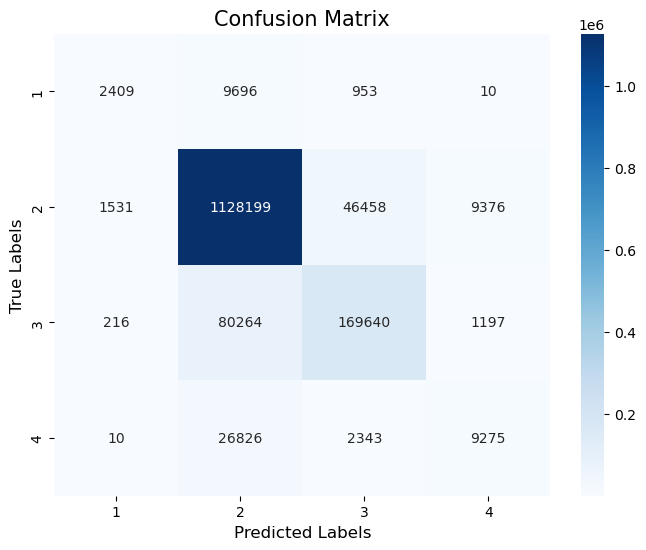

In [11]:
# Confusion Matrix

y_pred = clf.predict(X_test)
cm=confusion_matrix(y_test,y_pred,labels=[1,2,3,4])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1','2','3','4'], yticklabels=['1','2','3','4'])

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [12]:
# Compute AUC for each class (One-vs-Rest)
y_pred_prob = clf.predict_proba(X_test)
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3, 4])


roc_auc_per_class = {}
for i in range(4):  # Number of classes
    roc_auc_per_class[i] = roc_auc_score(y_test_binarized[:, i], y_pred_prob[:, i])

print("AUC for each class:", roc_auc_per_class)


AUC for each class: {0: 0.8319058264364831, 1: 0.9062926427470424, 2: 0.9379795562975831, 3: 0.8675413448971491}


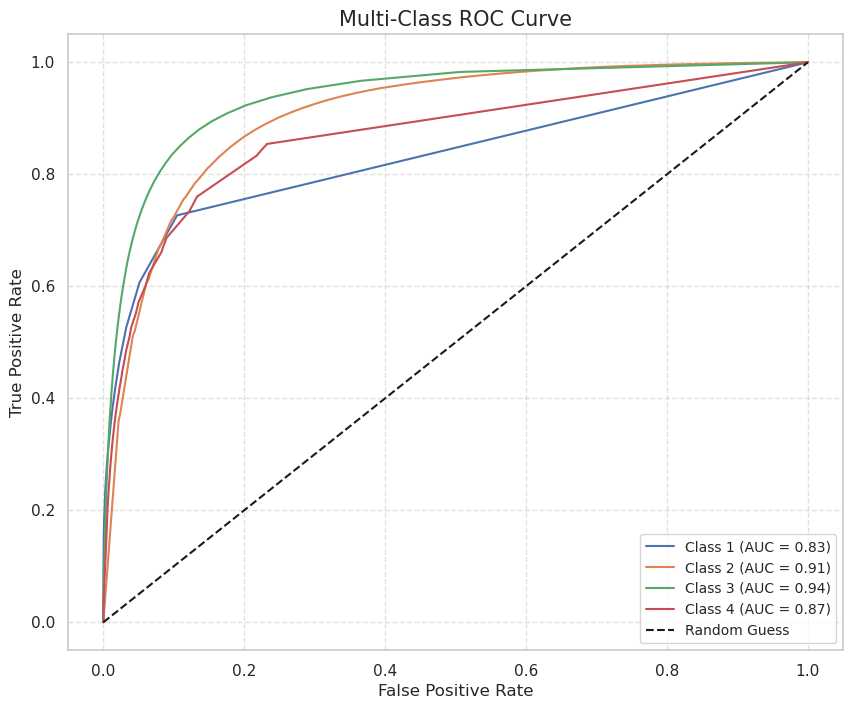

In [13]:
# Plotting the ROC AUC curve

fpr = {}
tpr = {}
for i in range(y_test_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])

plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

for i in range(y_test_binarized.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc_per_class[i]:.2f})')

# Add diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class ROC Curve', fontsize=15)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.6, linestyle='--')
plt.show()


# Visualization

In [6]:
import folium
from folium.plugins import MarkerCluster
import geopandas
import geoplot as gplt
import geoplot.crs as gcrs

In [7]:
df=pd.read_csv('Edited_US_accidents.csv')

In [8]:
df['Weather_Condition']

0             Light Rain
1             Light Rain
2               Overcast
3          Mostly Cloudy
4          Mostly Cloudy
               ...      
7442009             Fair
7442010             Fair
7442011    Partly Cloudy
7442012             Fair
7442013             Fair
Name: Weather_Condition, Length: 7442014, dtype: object

In [9]:
cities=df.City.unique()
cities_by_acc=df.City.value_counts()
cities_by_acc.head(20)

City
Miami            183458
Houston          166703
Los Angeles      153471
Charlotte        137963
Dallas           129777
Orlando          108722
Austin            93210
Raleigh           85631
Nashville         72733
Baton Rouge       70729
Atlanta           67435
Sacramento        65478
San Diego         54791
Phoenix           52184
Minneapolis       51291
Richmond          46836
Oklahoma City     45861
Jacksonville      41998
Tucson            38135
San Antonio       37541
Name: count, dtype: int64

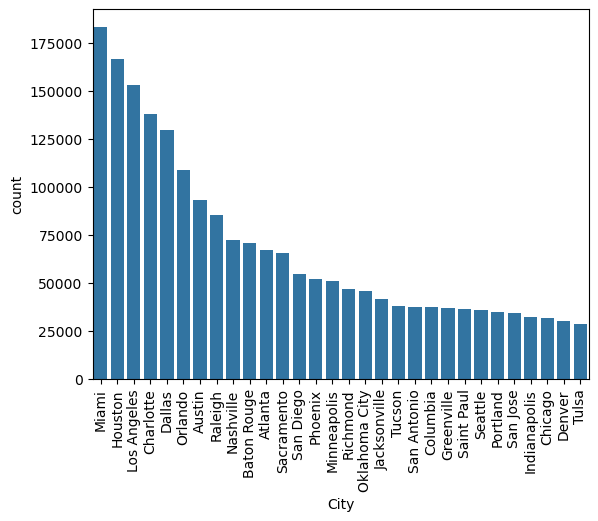

In [10]:
#Plotting top 30 cities
sns.barplot(cities_by_acc[:30])
plt.xticks(rotation=90)
plt.show()

In [11]:
weather=df['Weather_Condition'].unique()
weather_by_acc=df['Weather_Condition'].value_counts()
weather_by_acc.head(5)

Weather_Condition
Fair             2506331
Mostly Cloudy    1006028
Clear             803313
Cloudy            802578
Partly Cloudy     690113
Name: count, dtype: int64

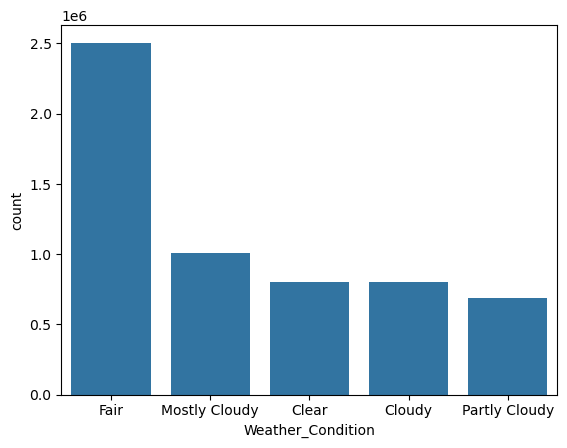

In [12]:
sns.barplot(weather_by_acc[:5])
plt.xticks(rotation=0)
plt.show()

In [15]:
gdf_severity = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Start_Lng, df.Start_Lat))

744201 accidents


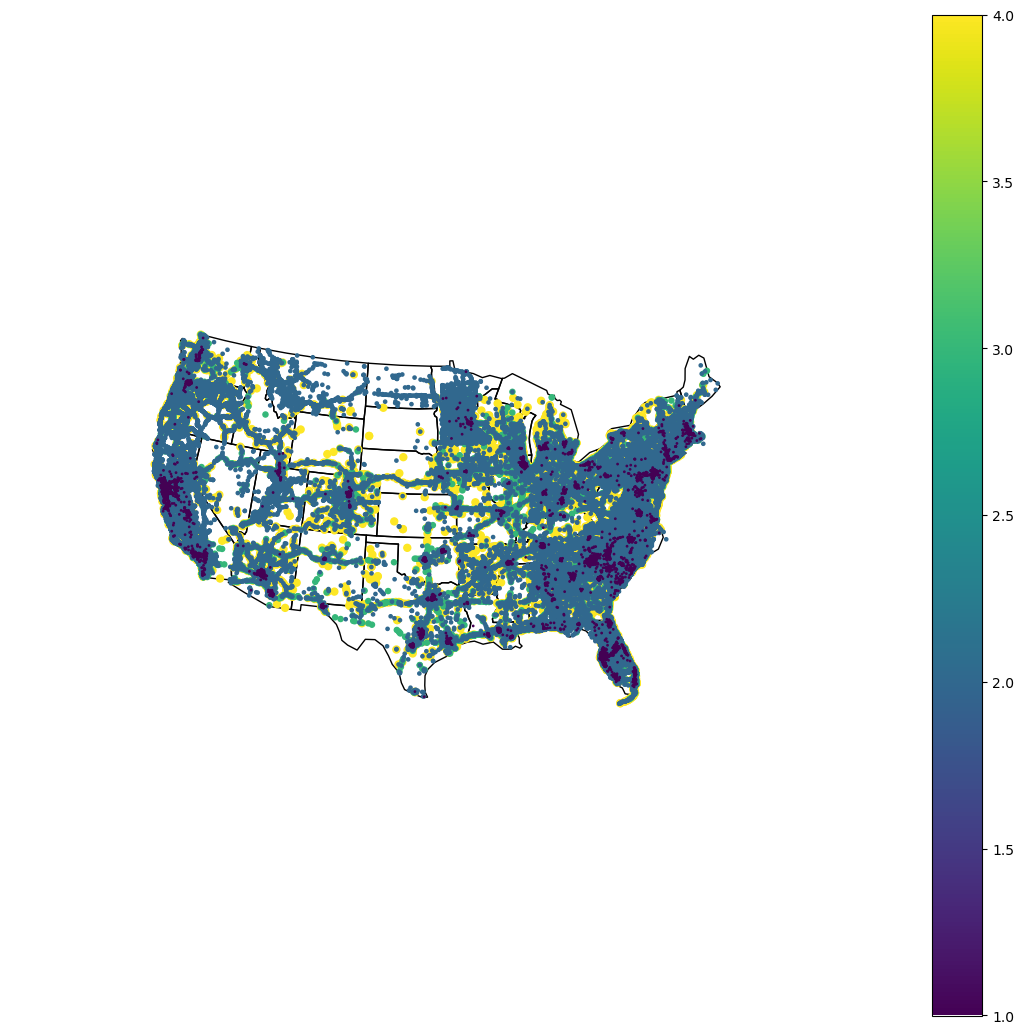

In [16]:
gdfs_sample = gdf_severity.sample(int(len(gdf_severity)/10))
print('{} accidents'.format(int(len(gdfs_sample))))

contiguous_usa = geopandas.read_file(gplt.datasets.get_path('contiguous_usa'))
ax = gplt.polyplot(
    contiguous_usa,
    projection=gcrs.AlbersEqualArea(),
    figsize=(14, 13)
)
gplt.pointplot(gdfs_sample, ax=ax, hue=gdfs_sample['Severity'], scale=gdfs_sample.Severity, legend=True, legend_var='hue')
plt.show()

In [17]:
# Coordinates of the US cities
us_cities_coords = {
    "New York": {"lat": 40.7128, "lon": -74.0060},
    "Los Angeles": {"lat": 34.0522, "lon": -118.2437},
    "Chicago": {"lat": 41.8781, "lon": -87.6298},
    "Houston": {"lat": 29.7604, "lon": -95.3698},
    "Phoenix": {"lat": 33.4484, "lon": -112.0740},
    "Philadelphia": {"lat": 39.9526, "lon": -75.1652},
    "San Antonio": {"lat": 29.4241, "lon": -98.4936},
    "San Diego": {"lat": 32.7157, "lon": -117.1611},
    "Dallas": {"lat": 32.7767, "lon": -96.7970},
    "San Jose": {"lat": 37.3382, "lon": -121.8863},
    "Austin": {"lat": 30.2672, "lon": -97.7431},
    "Jacksonville": {"lat": 30.3322, "lon": -81.6557},
    "Fort Worth": {"lat": 32.7555, "lon": -97.3308},
    "Columbus": {"lat": 39.9612, "lon": -82.9988},
    "San Francisco": {"lat": 37.7749, "lon": -122.4194},
    "Charlotte": {"lat": 35.2271, "lon": -80.8431},
    "Indianapolis": {"lat": 39.7684, "lon": -86.1581},
    "Seattle": {"lat": 47.6062, "lon": -122.3321},
    "Denver": {"lat": 39.7392, "lon": -104.9903},
    "Washington": {"lat": 38.9072, "lon": -77.0369}
}

In [ ]:
from folium.plugins import HeatMap

def create_heatmap(df, latitude, longitude, zoom, tiles='OpenStreetMap'):
    heat_data = [[row['Start_Lat'], row['Start_Lng']] for index, row in df.iterrows()]
    world_map = folium.Map(location=[latitude, longitude], zoom_start=zoom, tiles=tiles)
    HeatMap(heat_data).add_to(world_map)
    return world_map

map_us_heatmap = create_heatmap(df.sample(100000), us_cities_coords['Los Angeles']['lat'], us_cities_coords['Los Angeles']['lon'], 10)
map_us_heatmap